In [20]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

import scipy.stats as ss
from scipy import optimize
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
from scipy.special import beta as beta_fun

from itertools import product
import datetime as dt

In [2]:
#import fitters
from lifetimes import BetaGeoBetaBinomFitter
from blank_fitter import BlankFitter, BetaGeoBetaBinomEditFitter, S_w, r_w,  R_w
from drawing import *

#import requirements
import lifetimes
import numpy as np
import pandas as pd

# SETTINGS

In [11]:
ACTIVATION_DATE='2022-03-31'
T = 668

ALPHA, BETA = 1.49048904, 0.64736427
GAMMA, DELTA = 1.89446505, 2.97693934
THETA, P = None, None
C = 0.325
SIZE = 3000

/var/folders/80/4x2xdgt10slbgh_x044_xv3900lmbn/T/ipykernel_53093/1972533567.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  draw_betas(ALPHA, BETA, GAMMA, DELTA)[0].show()


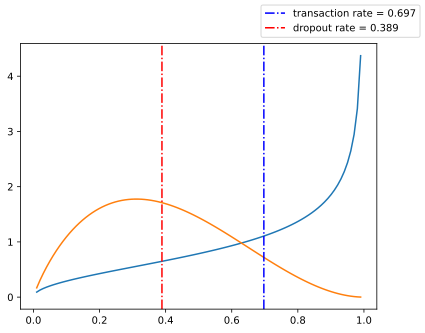

In [12]:
draw_betas(ALPHA, BETA, GAMMA, DELTA)[0].show()

# Generate data

In [13]:
from generate_data import dWeib, beta_dWeib_transaction_model

np.random.seed(1234)
df, trace = beta_dWeib_transaction_model(T, ALPHA, BETA, GAMMA, DELTA, size=SIZE, c=C)
df

,customer_id,frequency,recency,n_periods,p,theta,alive,death_time,opportunities
0,0,0,0,668.0,0.611691,0.491332,0.0,1.0,0.0
1,1,0,0,668.0,0.679264,0.696127,0.0,1.0,0.0
2,2,6,10,668.0,0.589171,0.570102,0.0,11.0,10.0
3,3,0,0,668.0,0.030403,0.697636,0.0,2.0,1.0
4,4,95,98,668.0,0.937926,0.442394,0.0,100.0,99.0
...,...,...,...,...,...,...,...,...,...
2995,2995,2,2,668.0,0.749344,0.426033,0.0,3.0,2.0
2996,2996,0,0,668.0,0.847058,0.556974,0.0,1.0,0.0
2997,2997,0,0,668.0,0.554702,0.358935,0.0,1.0,0.0
2998,2998,0,0,668.0,0.905648,0.599237,0.0,1.0,0.0


## Transaction data

In [14]:
from utils import *

transaction_raw = transform_trace(
    trace, 
    customer_id_col='id',
    datetime_col='date',
    activation_date=ACTIVATION_DATE
)

transaction_raw.head()

,id,date,period
0,0,2022-03-31,0
1,1,2022-03-31,0
2,2,2022-03-31,0
3,3,2022-03-31,0
4,4,2022-03-31,0


In [15]:
transaction_data = transform_transactions(
    transaction_raw,
    'id', 'date',
    activation_date=pd.to_datetime(ACTIVATION_DATE)
)
# transaction_data.columns=['date','id', 'period']
transaction_data.head()

,date,id,period
0,2022-03-31,0,0.0
1,2022-03-31,1,0.0
2,2022-03-31,2,0.0
3,2022-03-31,3,0.0
4,2022-03-31,4,0.0


# E(R)

/var/folders/80/4x2xdgt10slbgh_x044_xv3900lmbn/T/ipykernel_53093/2787710891.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


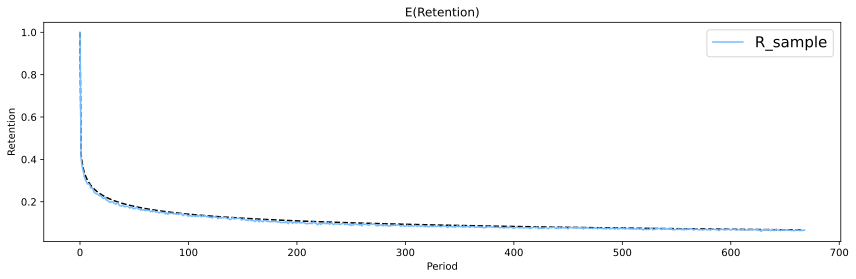

In [17]:
fig, axs = plt.subplots(1, 1)
fig.set_figheight(4)
fig.set_figwidth(12)

period = np.arange(T)
R_win = lambda t: R_w(t, ALPHA, BETA, GAMMA, DELTA, c=C, theta=THETA, p=P)
axs.plot(period, R_win(period), color='black', ls='--')

cap = len(transaction_data[transaction_data['date'] == pd.to_datetime(ACTIVATION_DATE)]['id'].unique())
#print(cap)
transaction_data_ = transaction_data#[transaction_data['date'] >= dt.datetime(2022,4,11)]
R_dayly = transaction_stream(transaction_data_, 'id', 'date', freq='D')
axs.plot(np.arange(len(R_dayly)), R_dayly['id'] / cap,color='#75bbfd', label="R_sample")

'''
EPOCHS = 100
for _ in range(EPOCHS):
    df, trace = beta_dWeib_transaction_model(T, ALPHA, BETA, GAMMA, DELTA, size= SAMPLE_SIZE, c=0.5)
    transaction_raw = transform_trace(trace, activation_date=ACTIVATION_DATE)
    transaction_data = transform_transactions(
        transaction_raw,
        'customer_id', 'date',
        activation_date=pd.to_datetime(ACTIVATION_DATE)
    )
    transaction_data.columns=['date','id', 'period']
    cap = len(transaction_data[transaction_data['date'] == pd.to_datetime(ACTIVATION_DATE)]['id'].unique())
    #print(cap)
    transaction_data_ = transaction_data#[transaction_data['date'] >= dt.datetime(2022,4,11)]
    R_dayly = transaction_stream(transaction_data_, 'id', 'date', freq='D')
    axs.plot(np.arange(len(R_dayly)), R_dayly['id'] / cap, color='#516572', alpha=0.01)
'''

axs.legend(fontsize=15)
axs.set_title("E(Retention)")
axs.set(xlabel='Period', ylabel='Retention')
fig.tight_layout()
fig.show()

# Summary 

In [18]:
from lifetimes.utils import summary_data_from_transaction_data

summary = summary_data_from_transaction_data(
    transaction_data, 
    'id', 'date', monetary_value_col=None,
    freq='D', 
    freq_multiplier=1)

summary.head()

,frequency,recency,T
id,,,
0,0.0,0.0,668.0
1,0.0,0.0,668.0
2,6.0,10.0,668.0
3,0.0,0.0,668.0
4,95.0,98.0,668.0


## LLH 

In [28]:
def calc_loglikelihood(model, df, alpha, beta, gamma, delta, c=None, theta=None, p=None):
    params = np.array([alpha, beta, gamma, delta])
    if c:
        return model._loglikelihood(params, df['frequency'], df['recency'], df['T'], c)
    else:
        return model._loglikelihood(params, df['frequency'], df['recency'], df['T'])
    
print(ALPHA, BETA, GAMMA, DELTA)
print(ALPHA/(ALPHA + BETA), GAMMA/(GAMMA+DELTA))
yf = summary.copy()
yf

1.49048904 0.64736427 1.89446505 2.97693934
0.6971895747140856 0.38889504921598184


,frequency,recency,T
id,,,
0,0.0,0.0,668.0
1,0.0,0.0,668.0
2,6.0,10.0,668.0
3,0.0,0.0,668.0
4,95.0,98.0,668.0
...,...,...,...
2995,2.0,2.0,668.0
2996,0.0,0.0,668.0
2997,0.0,0.0,668.0


# FIT

### lifetimes version

In [34]:
# the model did not converge.
'''
bgf_v0 = BetaGeoBetaBinomFitter(penalizer_coef=0.0)
bgf_v0.fit(summary['frequency'], summary['recency'], summary['T'], tol=1e-6)

print(bgf_v0)
bgf_v0.summary
'''
print("The model did not converge")

The model did not converge


### edit version

In [22]:
bgf_v1 = BetaGeoBetaBinomEditFitter(penalizer_coef=0.0)
bgf_v1.fit(summary['frequency'], summary['recency'], summary['T'], tol=1e-6)

print(bgf_v1)
bgf_v1.summary

<lifetimes.BetaGeoBetaBinomEditFitter: fitted with 3000 subjects, alpha: 1.35, beta: 0.65, delta: 0.47, gamma: 0.27>


,coef,se(coef),lower 95% bound,upper 95% bound
alpha,1.348625,NaN,NaN,NaN
beta,0.654095,NaN,NaN,NaN
gamma,0.268724,NaN,NaN,NaN
delta,0.466959,NaN,NaN,NaN


/var/folders/80/4x2xdgt10slbgh_x044_xv3900lmbn/T/ipykernel_53093/3528977546.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  draw_hists(df, bins=30,figure=(fig, axs))[0].show()


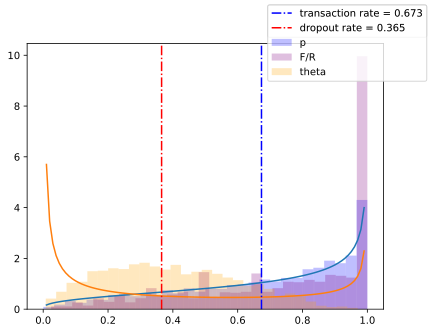

In [23]:
fig, axs = draw_betas(*bgf_v1.params_)
#fig.show()
draw_hists(df, bins=30,figure=(fig, axs))[0].show()

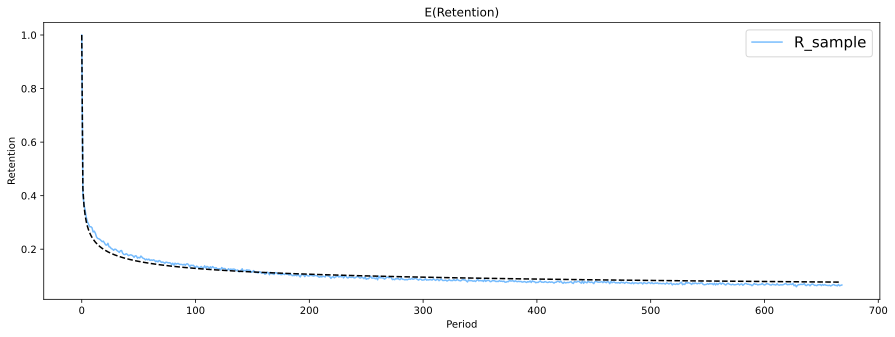

In [26]:
figr, axsr = draw_daily_retention(
    transaction_data#[transaction_data['date'] >= dt.datetime(2022,4,11)]
)

figw, axsw = draw_daily_wretention(T,
    *bgf_v1.params_, 1, None, None,
    figure=(figr, axsr),
    clr='black'
)

In [38]:
calc_loglikelihood(bgf_v1, yf, *bgf_v1.params_, theta=None, p=None).mean()

-47.17432568195112

### result version

In [30]:
bwf = BlankFitter(penalizer_coef=0.0, c=C)
bwf.fit(summary['frequency'], summary['recency'], summary['T'], tol=1e-6)

print(bwf)
bwf.summary

<lifetimes.BlankFitter: fitted with 3000 subjects, alpha: 1.41, beta: 0.65, delta: 2.83, gamma: 1.86>


,coef,se(coef),lower 95% bound,upper 95% bound
alpha,1.405923,NaN,NaN,NaN
beta,0.653121,NaN,NaN,NaN
gamma,1.859809,NaN,NaN,NaN
delta,2.827354,NaN,NaN,NaN


/var/folders/80/4x2xdgt10slbgh_x044_xv3900lmbn/T/ipykernel_53093/691318354.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  draw_hists(df, bins=30,figure=(fig, axs))[0].show()


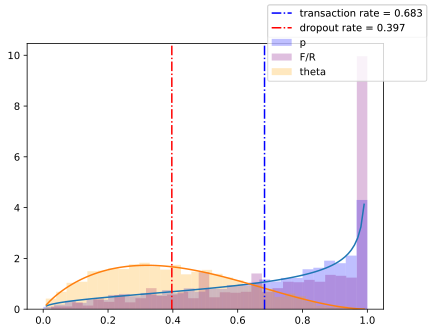

In [31]:
fig, axs = draw_betas(*bwf.params_)
#fig.show()
draw_hists(df, bins=30,figure=(fig, axs))[0].show()

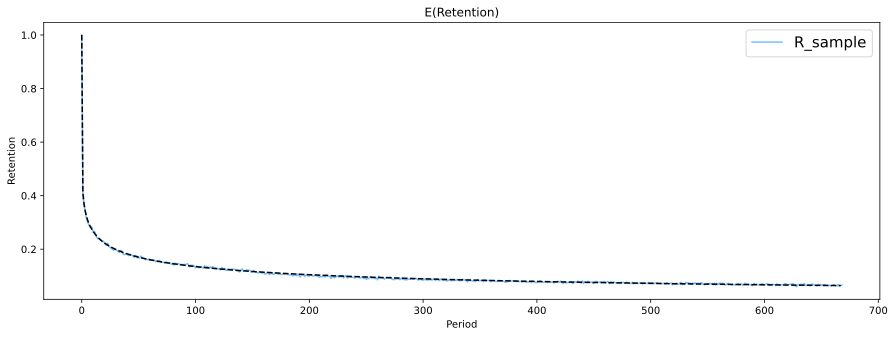

In [32]:
figr, axsr = draw_daily_retention(
    transaction_data#[transaction_data['date'] >= dt.datetime(2022,4,11)]
)

figw, axsw = draw_daily_wretention(T,
    *bwf.params_, C, None, None,
    figure=(figr, axsr),
    clr='black'
)

In [39]:
calc_loglikelihood(bwf, yf, *bwf.params_, c=C, theta=None, p=None).mean()

-47.15703644556882

In [40]:
#check consistency
calc_loglikelihood(bwf, yf, *bgf_v1.params_, c=1, theta=None, p=None).mean()

-47.17432568194854

In [41]:
calc_loglikelihood(bgf_v1, yf, *bgf_v1.params_, theta=None, p=None).mean()

-47.17432568195112